<a href="https://colab.research.google.com/github/ThiPauli/Churn_Predicition/blob/main/Churn_Prediction_with_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A **classification problem** in order to predict whethear a customer will churn or not the company.

Context: To meet the need of surviving in the competitive environment, the retention of existing customers has become a huge challenge. It is stated that the cost of acquiring a new customer is far more than that for retaining the existing one.

The task is to create a model which can predict accurately but also we are more interested in reduce situtations where customers would churn and we ended up predicting that they stay in the company. For this reason, the goal is to evaluate Recall metric in order to achieve it.

Here the steps I define important for our problem:
- Loading the Data and Understanding it a high level.
- Exploratory Data Analysis
- Data Preprossesing & Feature engineering
- Modeling
- Evaluating and Visualizing the results

This data set contains customer level information for a telecom company. It is available at https://www.kaggle.com/blastchar/telco-customer-churn

Useful Resources:

https://www.kaggle.com/kaanboke/xgboost-lightgbm-catboost-imbalanced-data/notebook

https://www.analyticsvidhya.com/blog/2021/06/exploratory-data-analysis-using-data-visualization-techniques/

https://machinelearningmastery.com/neural-network-for-banknote-authentication/

https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/02_neural_network_classification_in_tensorflow.ipynb

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

https://www.datascienceblog.net/post/machine-learning/interpreting-roc-curves-auc/

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report

## Data Understading:

Brief analysis on how the data looks like!

The data set includes information about:
- `Customers who left within the last month` – the column is called Churn.
- `Services that each customer has signed up for` – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies.
- `Customer account information` – how long they’ve been a customer (tenure), contract, payment method, paperless billing, monthly charges, and total charges
- `Demographic info about customers` – gender, age range, and if they have partners and dependents.

In [2]:
df = pd.read_csv('Dataset-Churn.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.shape

(7043, 21)

In [5]:
# Let's check if it has missing values
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

### Apparently it does not have missing values, but I will dive deeper later on to double check it

In [7]:
# Let's drop the customerID, which I assume it will not be relevant for now
df1 = df.copy()
df1.drop('customerID', axis=1, inplace=True)
df1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
# convert TotalCharges column, which is an object to numeric.
# errors coerce as it has some rows with empty values.
df1['TotalCharges'] = pd.to_numeric(df1['TotalCharges'], errors='coerce')


In [9]:
df1.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

#### Now, it has 11 rows with NaN in TotalCharges. For simplicity, I will drop them.

In [10]:
df1.dropna(inplace=True)

In [11]:
df1.shape

(7032, 20)

## **Exploratory Data Analysis**:
- How many customers continue with the company and didn't continue?
- And, which factores/features might lead to its decision?

In [12]:
df1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


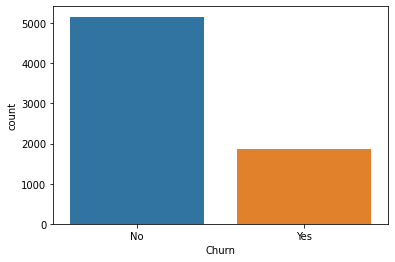

In [13]:
sns.countplot(x=df1['Churn'])
plt.show()

In [14]:
percentage = df1['Churn'].value_counts(normalize=True)
print(f'The percentage of Churn is {percentage[1]*100:.2f}% and not churn is {percentage[0]*100:.2f}%')

The percentage of Churn is 26.58% and not churn is 73.42%


### As we can see: It contains **imbalanced data**, meaning that there are more samples of customers who continued with the company than left.

In [15]:
# Let's transform the column contract in a numerical way to represent its period.

#add new column
df1['PeriodContract'] = df1['Contract']

df1['PeriodContract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [16]:
# Transforming it to number of months.

df1['PeriodContract'].replace('Month-to-month', 1, inplace=True)
df1['PeriodContract'].replace('One year', 12, inplace=True)
df1['PeriodContract'].replace('Two year', 24, inplace=True)

In [17]:
df1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,PeriodContract
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,12
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,12
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1


In [18]:
# Also, let's encode the target column (Churn) to make analysis together with the numerical columns as well.

df1['ChurnEncoded'] = df1['Churn']
df1['ChurnEncoded'].replace('No', 0, inplace=True)
df1['ChurnEncoded'].replace('Yes', 1, inplace=True)

In [19]:
# Getting the numerical and categorical columns respectively

numerical = df1.select_dtypes('number').columns
categorical = df1.select_dtypes('object').columns

### **Numerical Features:**

Let's first analyse the numerical features and their relationships with the target values.

In [20]:
df1[numerical].describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,PeriodContract,ChurnEncoded
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441,8.813851,0.265785
std,0.368844,24.545260,30.085974,2266.771362,9.541690,0.441782
min,0.000000,1.000000,18.250000,18.800000,1.000000,0.000000
25%,0.000000,9.000000,35.587500,401.450000,1.000000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,1.000000,0.000000
75%,0.000000,55.000000,89.862500,3794.737500,12.000000,1.000000
max,1.000000,72.000000,118.750000,8684.800000,24.000000,1.000000


In [21]:
def plot_distribution(columns, data):

  """
  Plotting the distribution for each numerical column in respect with the target variable.
  """

  for col in columns:
    if col is 'ChurnEncoded': #just ensure to not plot Churn
      continue

    sns.displot(data, x=col, hue="Churn", element="step", bins=20)
    plt.title(f'{col} distribution')
    plt.show()

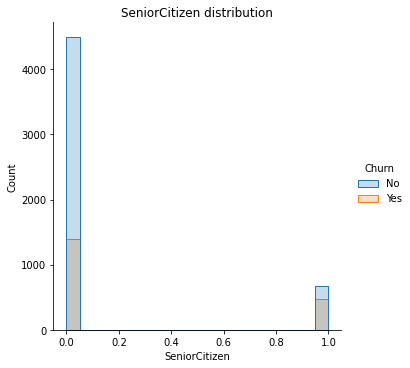

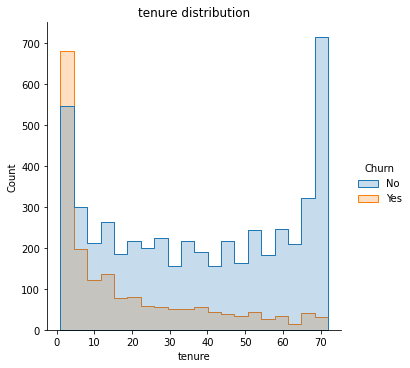

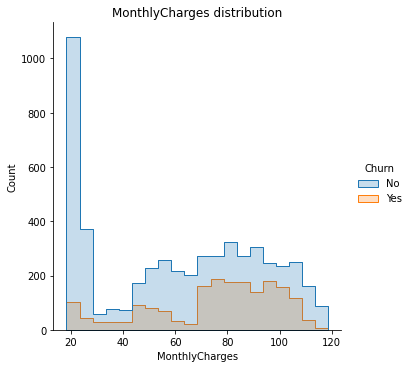

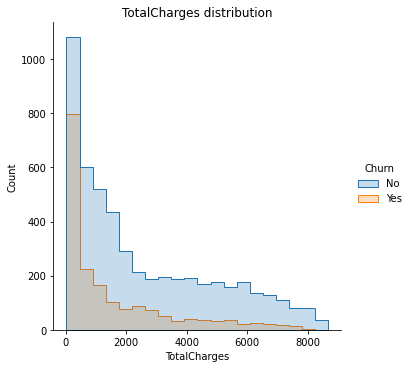

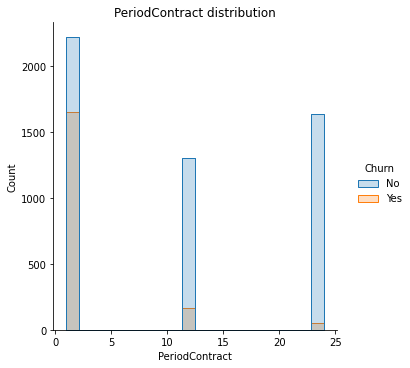

In [22]:
plot_distribution(columns=numerical, data=df1)

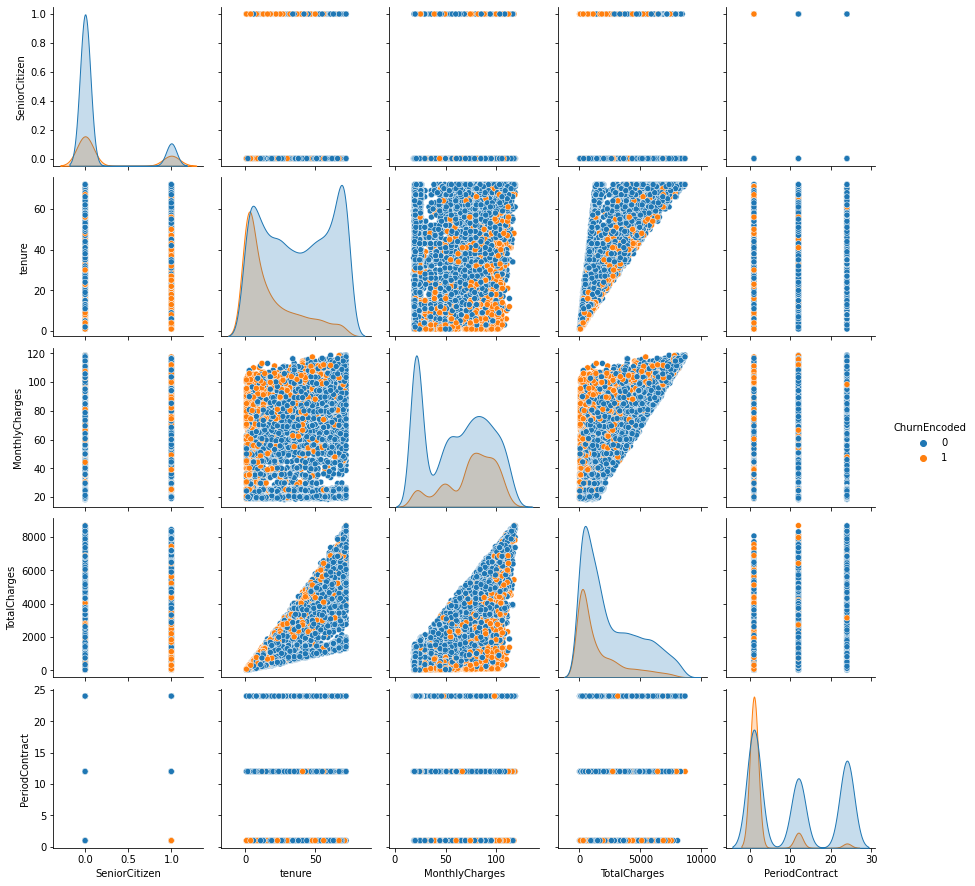

In [23]:
# Churn Encoded: 0 (not churn), 1(churn)

sns.pairplot(df1[numerical], hue='ChurnEncoded')
plt.show()

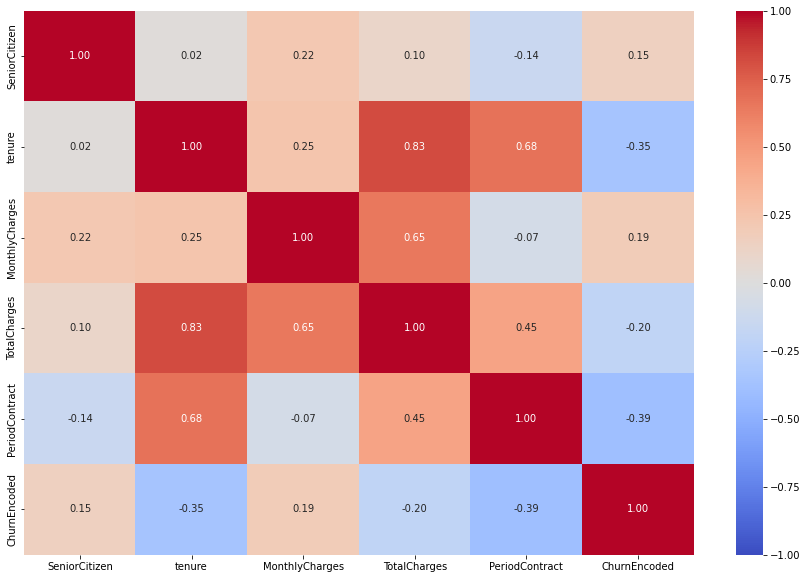

In [24]:
# plot correlation matrix

fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(df1[numerical].corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm', ax=ax)
plt.show()

### Explanation to understand some **numerical features** from the data:
`Tenure`: Indicates the total amount of months that the customer has been with the company.

`Senior Citizen`: Indicates if the customer is 65 or older, Yes (1) or No (0).


### Therefore, based on the plots above:
- The **Tenure distribution** shows that around half of customers in their first year yet, churn the company.
- As a consequence, it reflects that the customers who left earlier had **total charged smaller** as well as a **short period contract**.
- The **majority of Senior Citizen** decided to left the company.

### Based on the correlation matrix:

- There is a weak correlation between the **numerical features** and the **target variable**.
- There is strong correlation between **tenure** and **total charges**. The more you have been using the company services, the more you have been charged.
- **Senior citizen** more likely churn than younger customers.
- Customer with **higher monthly charges** are more likely churn.


In [25]:
df1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,PeriodContract,ChurnEncoded
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,12,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,12,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,1


In [26]:
churn_df = df1.groupby('Churn')[['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'PeriodContract']].mean().reset_index()
churn_df

,Churn,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,PeriodContract
0,No,0.128995,37.650010,61.307408,2555.344141,11.074956
1,Yes,0.254682,17.979133,74.441332,1531.796094,2.567683


In [27]:
def average_by_class(data):

  """
  Plot the average of the features by class (Churn: Yes or No)
  """

  for col in data.columns:
    if col == 'Churn': #just ensure to not plot Churn
      continue
    
    sns.barplot(x='Churn', y=col, data=data)
    plt.title(f'Average of {col}')
    plt.show()

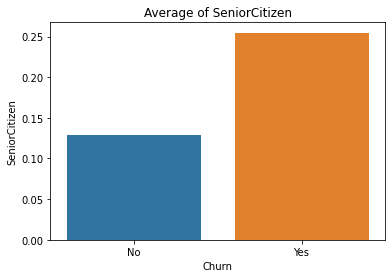

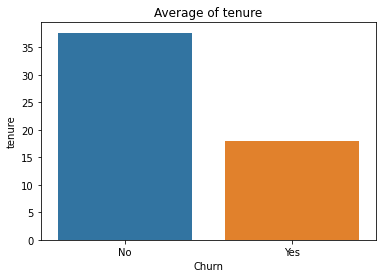

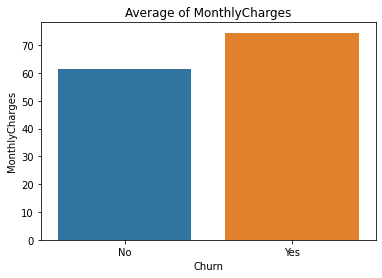

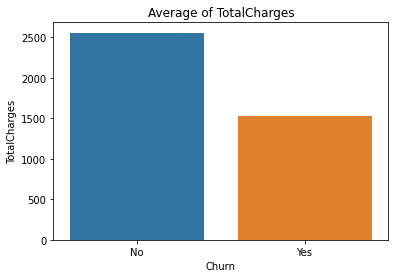

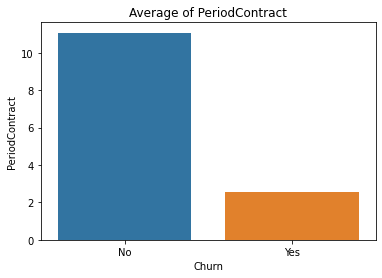

In [28]:
average_by_class(data=churn_df)

### Basically, we can see all the notation above making sense with the bar plots:

### **On average**:
- People churn with higher monthly charges.
- Short period of contracts for people who left the company, which led to lower tenure and total charges.

### **Categorical Features:**

Now let's analyse the categorical features and their relationships with the target values

In [29]:
#Getting the number of unique elements in each column

categorical_df = df1[categorical].nunique().reset_index()
categorical_df.columns=['features', 'count']

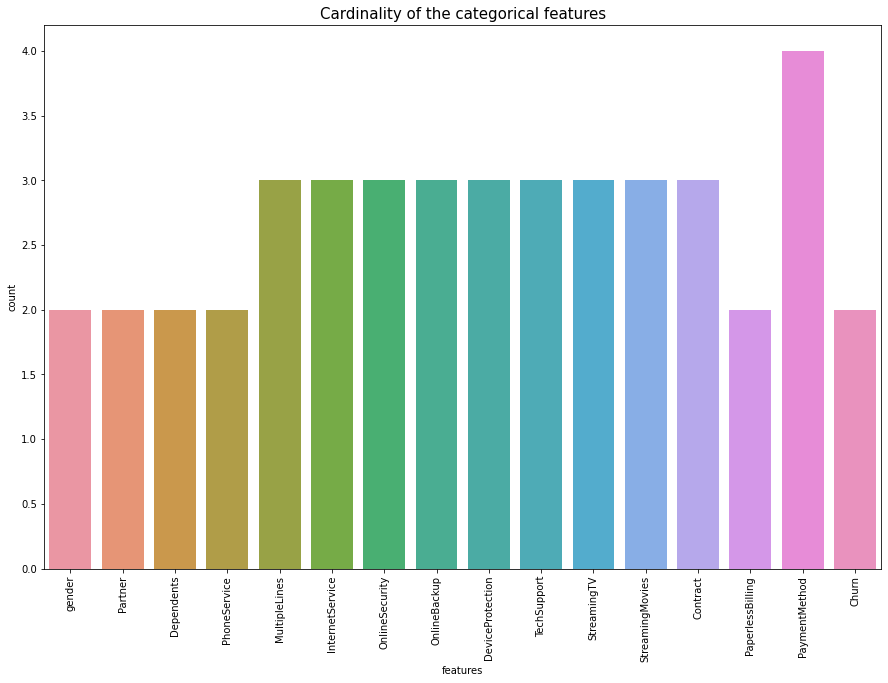

In [30]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.barplot(x='features', y='count', data=categorical_df, ax=ax)
ax.tick_params(axis='x', rotation=90)
plt.title('Cardinality of the categorical features', fontsize=15)

plt.show()

The cardinality (the number of unique elements in each column) ranges between 2 and 4, so the data does not have a high cardinality or zero variance issues.

In [31]:
# Getting the unique values of each categorical feature

for feature in df1[categorical].columns:
  print(f'{feature}: {df1[feature].unique()}')

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


As we can see, there are some relationships between the categorical features:
- `PhoneService > MultipleLines`: If the customer does not have Phone Services, automatically Multiple Lines is 'No phone service' and then it  means 'No' as well.

The same applies for:
- `InternetService > OnlineSecurity > OnlineBackup > DeviceProtection > ...`

It is better to reduce the dimensionallity of those features, so the only options will be Yes or No instead of Yes, No and No phone service/No internet service.

In [32]:
# replace No phone service/No internet service for No

df1['MultipleLines'].replace('No phone service','No', inplace=True)

df1['OnlineSecurity'].replace('No internet service', 'No', inplace=True)
df1['OnlineBackup'].replace('No internet service', 'No', inplace=True)
df1['DeviceProtection'].replace('No internet service', 'No', inplace=True)
df1['TechSupport'].replace('No internet service', 'No', inplace=True)
df1['StreamingTV'].replace('No internet service', 'No', inplace=True)
df1['StreamingMovies'].replace('No internet service', 'No', inplace=True)

In [33]:
df1['MultipleLines'].unique(), df1['OnlineSecurity'].unique()

(array(['No', 'Yes'], dtype=object), array(['No', 'Yes'], dtype=object))

Let's dive into each categorical feature to see their relationship with the target variable, starting by **Gender** 

In [34]:
# Counting the number of each unique value for the feature in each class (Churn: Yes or No)
table = pd.pivot_table(data=df1[categorical], index=['gender', 'Churn'], values='Contract', aggfunc='count').rename(columns={'Contract': 'Count'})

# Getting the percentage of each unique value
table['Percentage'] = table.groupby(level=0).apply(lambda x: round(100 * x / float(x.sum()), 2))

table.reset_index(inplace=True)
table

,gender,Churn,Count,Percentage
0,Female,No,2544,73.04
1,Female,Yes,939,26.96
2,Male,No,2619,73.80
3,Male,Yes,930,26.20


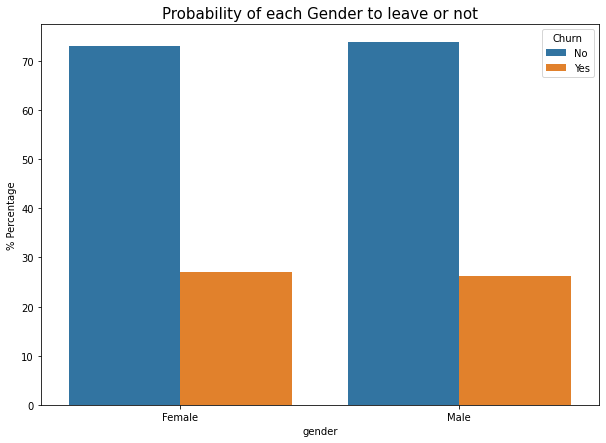

In [35]:
fig, ax = plt.subplots(figsize=(10, 7)) 
ax = sns.barplot(x='gender', y='Percentage', hue='Churn', data=table)

plt.ylabel('% Percentage')
plt.title('Probability of each Gender to leave or not', fontsize=15)
plt.show()

Making a function to display all the relationships between the categorical and the target (churn)

In [36]:
def probability_by_feature(data, columns):

  """
  Plotting the probability of each categorical feature related to the target value (Churn)
  """
  
  for feature in columns:
    if feature == 'Churn': #just ensure to not plot Churn
      continue

    # Counting the number of each unique value for the feature in each class (Churn: Yes or No)
    if feature != 'Contract': #Since I have to define one arbitrary column(feature) to count, when it makes the table with the index for Contract feature, it has to count in a different feature!
      table = pd.pivot_table(data=data[columns], index=[feature, 'Churn'], values='Contract', aggfunc='count').rename(columns={'Contract': 'Count'})
    else:
      table = pd.pivot_table(data=data[columns], index=[feature, 'Churn'], values='gender', aggfunc='count').rename(columns={'gender': 'Count'})

    # Getting the percentage of each unique value
    table['Percentage'] = table.groupby(level=0).apply(lambda x: round(100 * x / float(x.sum()), 2))

    table.reset_index(inplace=True)

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 7)) 
    sns.barplot(x=feature, y='Percentage', hue='Churn', data=table, ax=ax)
    plt.ylabel('% Percentage')
    plt.title(f'{feature}: Probability of customer churn', fontsize=15)
    plt.show()

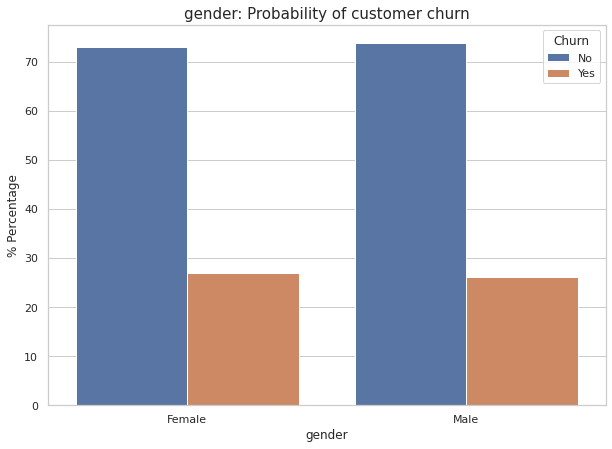

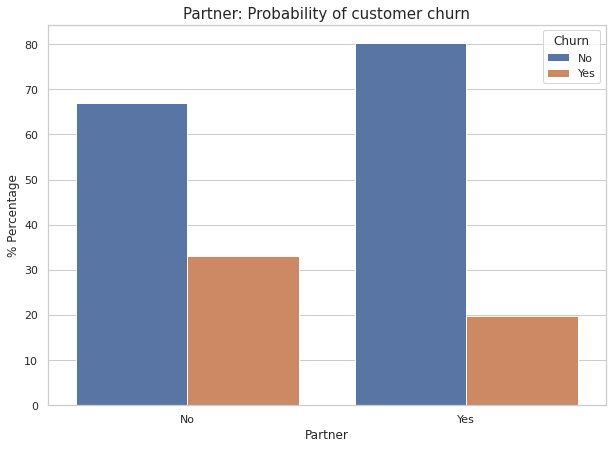

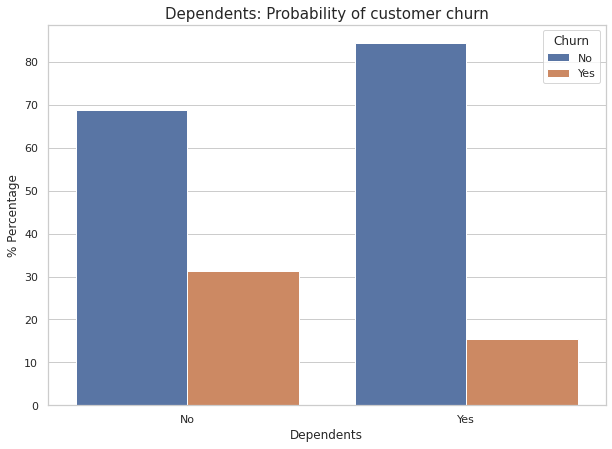

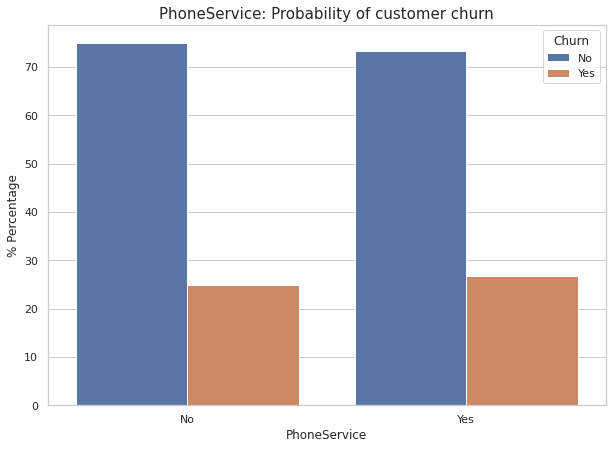

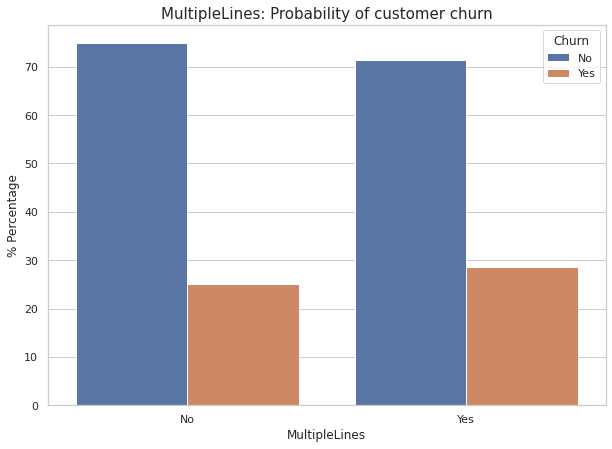

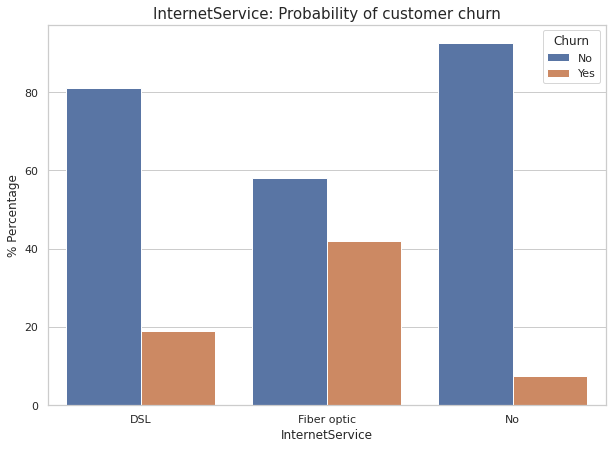

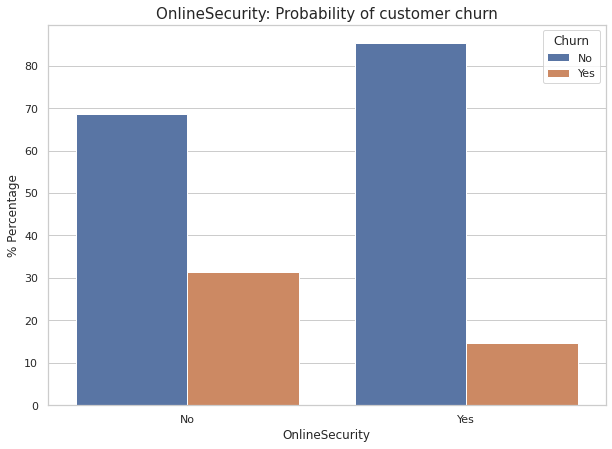

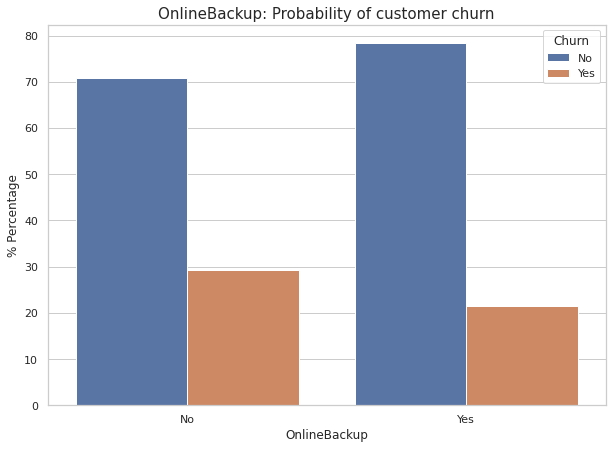

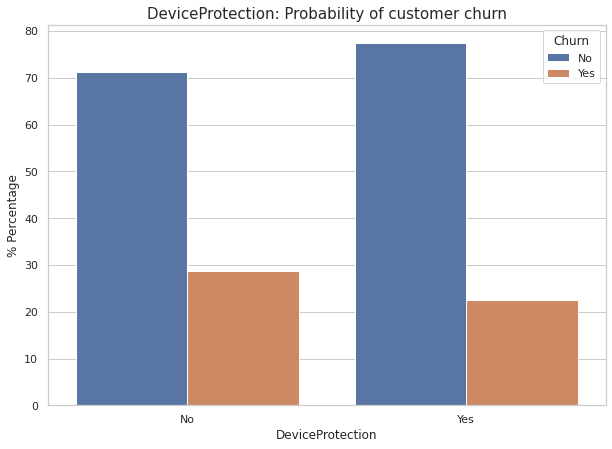

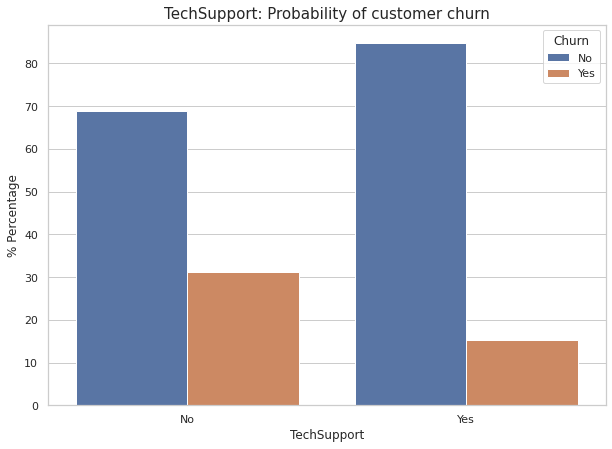

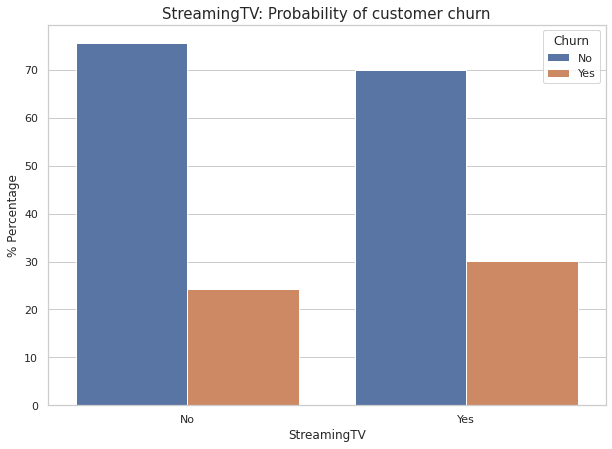

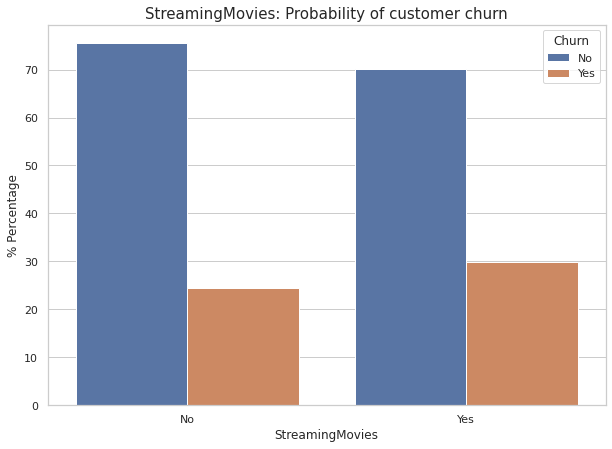

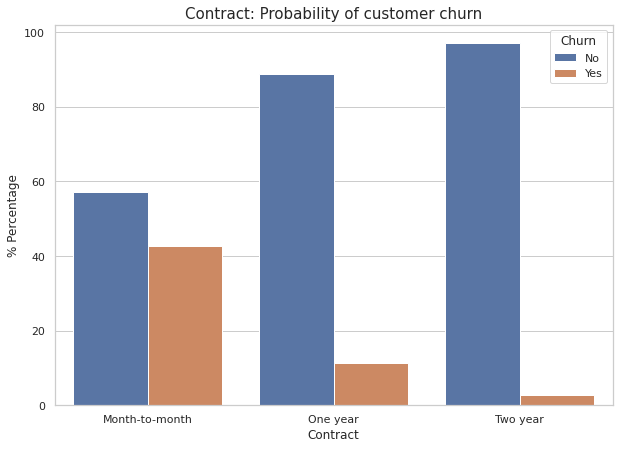

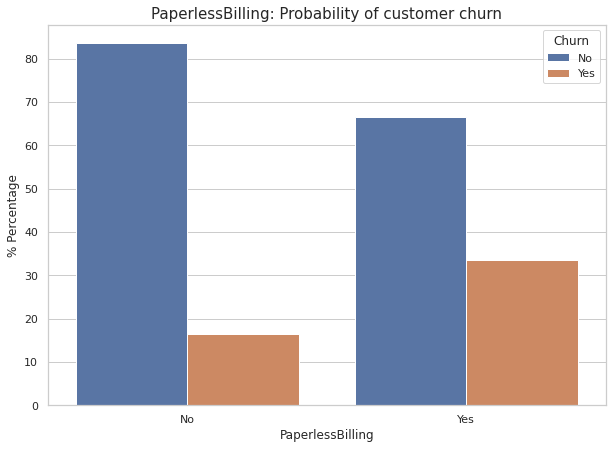

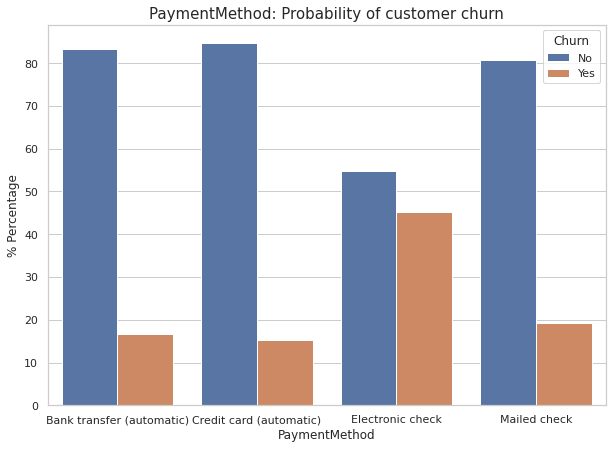

In [37]:
probability_by_feature(data=df1, columns=categorical)

### Sorting the categorical features and based on the bar plots above:
`Customer information:`
- **Gender**: The probability of both male and female to leave the company is basically the same. So, this feature might be redundant for our problem.
- **Partner**: Customers with no partner are more likely to leave the company. It means roughly **1.6x** more likely churn than customers with partner.
- **Dependends**: Customers with no dependents (if the customers live or not with their children, parents, grandparents, etc.) are more likely to leave the company. It means roughly **2x** more likely churn than customers with dependents.

`Services`:
- **Phone Service**: Slightly difference impacting whether the customer has phone service or not in order to leave the company. So, this feature might be redundant for our problem.
- **Multiple Lines**: Basically the same behaviour as the phone service feature.
- **Internet Service**: Customers who opted for Fiber Optic are more likely churn than customers who opted for DSL (**2.3x** more) and/or No Internet (**5.1x** more). The same is noted with customers who opted for DSL compared to No internet (**2.4x** more). Overall, customer who opted for having internet are more likely to churn.

`Positive Services Included:`
- **Online Security**: Customers who opted for having Online Security service are less likely churn (**2.2x** less).
- **Online Backup**: Customers who opted for having Online Backup service are less likely churn (**1.4x** less).
- **Device Protection**: Customers who opted for having Device Protection service are less likely churn (**1.3x** less).
- **Tech Support**: Customers who opted for having Tech Support service are less likely churn (**2.1x** less).

`Negative Services Included:`
- **Streaming TV**: Customers who opted for having Streaming TV service are more likely churn (**1.2x** more).
- **Streaming Movies**: Customers who opted for having Streaming Movies service are more likely churn (**1.2x** more).

`Contract and Payment:`
- **Contract Type**: As we evaluate this feature numerically as well, customers with short contracts are more likely churn than long contracts. Customer with one month contract are **14x** more likely churn than 2 years contract as well as **4x** more than 1 year contract. Overall, the longer the contract, the higher the probability of the customer stay with the company.
- **Paperless Billing**: Customers who opted for having Paperless Billing are more likely churn (**2.1x** more).
- **Payment Method**: Customers who opted for paying with Electronic Check are more likely churn than the other options. Almost 45% of the customers who chose Electronic Check left the company.

Thus, doing all this analysis we can see the features which have some positive and negative impacts with the target variable as well as some features which might be redudant for our problem.

Let's see some relationships between the **categorical** and **numerical** features.

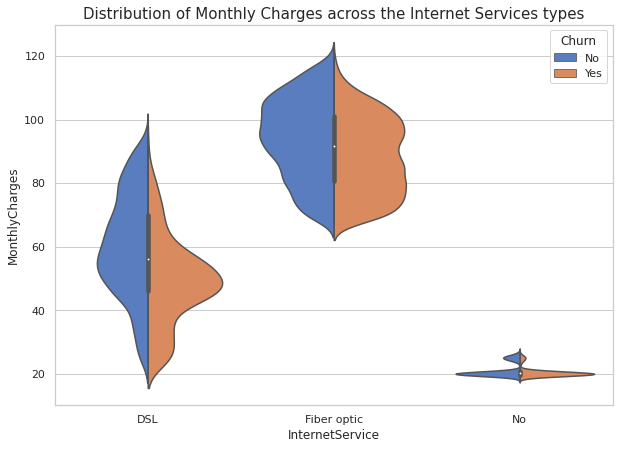

In [38]:
fig, ax = plt.subplots(figsize=(10, 7)) 
ax = sns.violinplot(x='InternetService', y='MonthlyCharges', hue='Churn', data=df1, palette='muted', split=True)

plt.title('Distribution of Monthly Charges across the Internet Services types', fontsize=15)
plt.show()

- Fiber Optic results in more expensive charges and customers might not have been pleased with the quality of this service versus price.
- Intersting that there are some customers who opted for DSL (slower connection), have higher charges and are less likely to churn the company.

## **Data Preprocessing & Modeling**:

Let's first set a baseline, a simple model which will be:
- with all features presents in the dataset.
- data preprocessing: Normalization the numerical and One Hot Encoding the non-numerical columns.
- One hidden layer only.

In [39]:
df1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,PeriodContract,ChurnEncoded
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,12,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,1
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,12,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,1


In [40]:
# Let's remember our data imbalance again

not_churn, churn = np.bincount(df1['ChurnEncoded'])
total = not_churn + churn
print(f'Total Samples: {total}\nChurn: {churn} ({(churn/total)*100:.2f}% of total)')

Total Samples: 7032
Churn: 1869 (26.58% of total)


In [41]:
# drop the Churn and PeriodContract columns (I prefer stay with ther Contract column instead of PeriodContract)
df1.drop(['Churn', 'PeriodContract'], axis=1, inplace=True)
df1.rename(columns={'ChurnEncoded': 'Churn'}, inplace=True)

# Tranforming the SeniorCitizen as a categorical (Yes or No) in order to one hot encode this column
df1['SeniorCitizen'] = df1['SeniorCitizen'].apply(lambda x: 'No' if x == 0 else 'Yes')

# Create X (features) & y (labels) values
X = df1.drop('Churn', axis=1)
y = df1['Churn']

# Getting the columns name for the preprocessing data pipeline
numerical_columns = X.select_dtypes('number').columns
categorical_columns = X.select_dtypes('object').columns

Preprocessing the data (Normalization and One Hot Encoding) using Scikit-Learn

In [42]:
#Preprocessing data (Normalization and One Hot Encoding)

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder

# Create column transformer (this will help us normalize/preprocess our data)
ct = make_column_transformer(
    (MinMaxScaler(), numerical_columns), # get all values between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), categorical_columns)
)

# ensure all numerical data are floating point values
X[numerical_columns] = X[numerical_columns].astype('float32')

# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # set random state for reproducible splits
print('Before applying the Preprocessing data:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Before applying the Preprocessing data: (5625, 19) (1407, 19) (5625,) (1407,)


In [43]:
# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
X_train = ct.transform(X_train)
X_test = ct.transform(X_test)
print('After applying the Preprocessing data:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

After applying the Preprocessing data: (5625, 39) (1407, 39) (5625,) (1407,)


In [44]:
def count_samples(y):
  """
  Show the amount of each target value after splitting
  """

  unique, counts = np.unique(y, return_counts=True)
  return pd.DataFrame({'Churn':unique, 'Counts':counts})

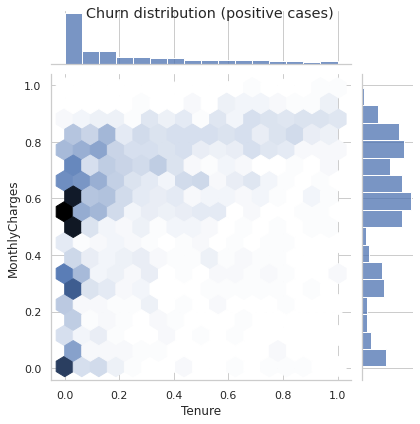

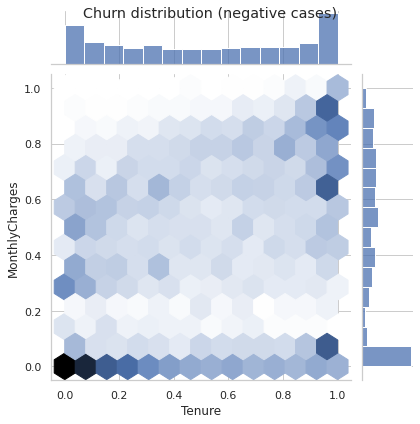

In [45]:
bool_y_train = y_train != 0 #mask to filter the training set

pos_df = pd.DataFrame(X_train[ bool_y_train]) #churn
neg_df = pd.DataFrame(X_train[~bool_y_train]) #not churn

sns.jointplot(x=pos_df[0], y=pos_df[1], # 0 : tenure	, 1: MonthlyCharges	
              kind='hex')
plt.xlabel('Tenure')
plt.ylabel('MonthlyCharges')
plt.suptitle('Churn distribution (positive cases)')

sns.jointplot(x=neg_df[0], y=neg_df[1],
              kind='hex')
plt.xlabel('Tenure')
plt.ylabel('MonthlyCharges')
_ = plt.suptitle('Churn distribution (negative cases)')

After Normalizing the data, let's look at the data distribution for positive and negative samples over the Tenure and Monthly Charges.

The numerical features was normalized and we can see some differenciations on their distributions:
- **Churn (positive):** It is more concentrate in lower Tenures and higher Monthly Charges.
- **Not Churn (negative):** It is more concentrate in higher Tenures and lower Monthly Charges.

### Define the metrics which will evaluate the model performace:

Some point to pay attention:
- **Accuracy** (percentage of examples correctly classified) might not be a helpful metric for this task because it can achieve a high accuracy on this task by predicting False all the time. As we have less examples of Churn, if it gets wrong in all of them, it does not impact the accuracy. For example, out test set has 1407 samples, being 1033 as not churn and 374 as churn. Predicting false all the time would result: `(1033 / 1407) * 100 = 73.4%` accuracy


In [46]:
import tensorflow as tf

#defining the metrics
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

EPOCHS = 25 # number of chances for the model to look for the training set.

# larger than default batch size, because this is important to ensure that each batch has a decent chance of containing a few positive samples.
# If the batch size was too small, it has no churn examples to learn from.
BATCH_SIZE = 256

In [47]:
#define the model:

# number of features
n_features = X_train.shape[-1]

# Set random seed
tf.random.set_seed(42)

# Create a model
model_1 = tf.keras.Sequential([
          tf.keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)),
          tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(), # lr as default: 1e-3(0.001)
                metrics=METRICS
)

# Fit the model
history_1 = model_1.fit(X_train,
                        y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=(X_test, y_test))

Epoch 1/25
22/22 [==============================] - 3s 48ms/step - loss: 1.0418 - tp: 1452.0000 - fp: 3764.0000 - tn: 366.0000 - fn: 43.0000 - accuracy: 0.3232 - precision: 0.2784 - recall: 0.9712 - auc: 0.5809 - prc: 0.3151 - val_loss: 0.8238 - val_tp: 341.0000 - val_fp: 792.0000 - val_tn: 241.0000 - val_fn: 33.0000 - val_accuracy: 0.4136 - val_precision: 0.3010 - val_recall: 0.9118 - val_auc: 0.5873 - val_prc: 0.3036
Epoch 2/25
22/22 [==============================] - 0s 4ms/step - loss: 0.7048 - tp: 1016.0000 - fp: 2227.0000 - tn: 1903.0000 - fn: 479.0000 - accuracy: 0.5189 - precision: 0.3133 - recall: 0.6796 - auc: 0.5988 - prc: 0.3179 - val_loss: 0.6138 - val_tp: 154.0000 - val_fp: 297.0000 - val_tn: 736.0000 - val_fn: 220.0000 - val_accuracy: 0.6326 - val_precision: 0.3415 - val_recall: 0.4118 - val_auc: 0.6220 - val_prc: 0.3517
Epoch 3/25
22/22 [==============================] - 0s 4ms/step - loss: 0.5745 - tp: 324.0000 - fp: 410.0000 - tn: 3720.0000 - fn: 1171.0000 - accuracy:

Check the training and validation history

In [48]:
# Function borrowed from the TensorFlow website
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall', 'accuracy', 'auc']
  plt.figure(figsize=(16, 8))

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.6,1])
    elif metric == 'accuracy':
      plt.ylim([0.6,1])
    else:
      plt.ylim([0,1])

    plt.legend();

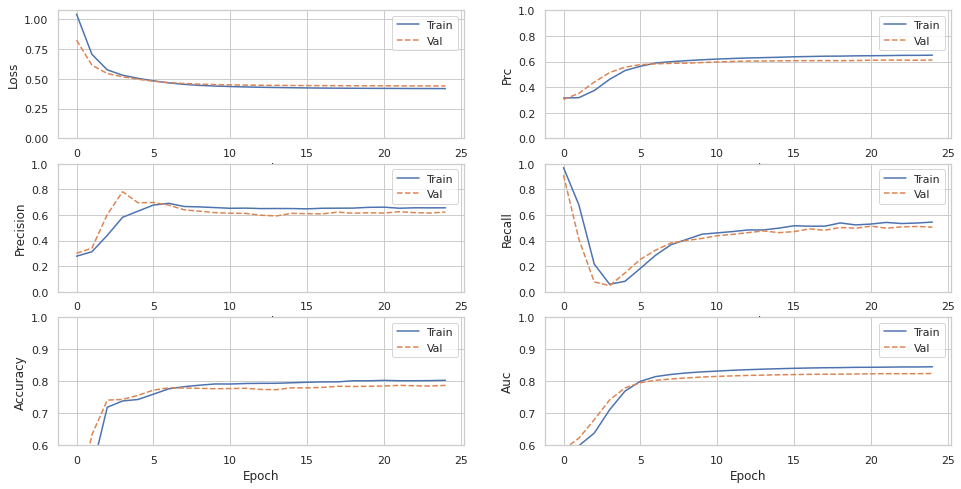

In [49]:
plot_metrics(history_1)

**Model 1 (Baseline model)** was defined as:
- Using one hidden layer with 16 nodes and one output layer (chosen arbitrarily)
- Using the ReLU activation function in the hidden layer and the “he_normal” weight initialization.
- Optimizer Adam with default learning rate.

Evaluating the model with confusion matrix to summarize the actual vs. predicted labels. I will calculate the accuracy, precision and recall using the test set, even though it was calculate when I specified in the validate set during training.

In [50]:
def get_results(model, name_model):
  """
  Evaluating the model in the test set using the metrics defined above
  """

  model_results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
  metric_names = model.metrics_names

  data = {'metric_names': metric_names, f'results_{name_model}': model_results}
  df = pd.DataFrame(data=data).set_index('metric_names').round(3).transpose()
  return df

In [51]:
results_model_1 = get_results(model_1, 'model_1')
results_model_1

metric_names,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
results_model_1,0.439,189.0,114.0,919.0,185.0,0.787,0.624,0.505,0.825,0.612


In [52]:
#function to plot the confunsion matrix. The threshold value is set as 0.5
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title(f'Confusion matrix @{p:.2f}')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Not Churn Predicted Correctly (True Negatives): ', cm[0][0])
  print('Churn Predicted Incorrectly - Customers who actually still with the company (False Positives): ', cm[0][1])
  print('Not Churn Predicted Incorrectly - Customers who actually left the company (False Negatives): ', cm[1][0])
  print('Churn Predicted Correctly (True Positives): ', cm[1][1])
  print('Total Customers that really left the company: ', np.sum(cm[1]))

In [53]:
# prediction probabilities for the training and testing set
y_pred_train_1 = model_1.predict(X_train, batch_size=BATCH_SIZE)
y_pred_test_1 = model_1.predict(X_test, batch_size=BATCH_SIZE)

Not Churn Predicted Correctly (True Negatives):  919
Churn Predicted Incorrectly - Customers who actually still with the company (False Positives):  114
Not Churn Predicted Incorrectly - Customers who actually left the company (False Negatives):  185
Churn Predicted Correctly (True Positives):  189
Total Customers that really left the company:  374


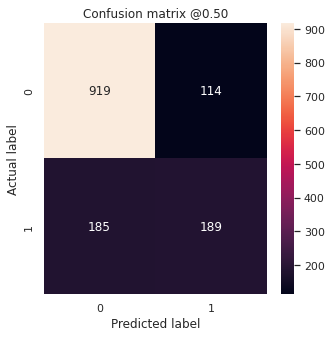

In [54]:
plot_cm(y_test, y_pred_test_1)

From the **confusion matrix** above:
- Our model is predicting almost a half of customer who did not churn, but they actually left the company. In this case, it would be better to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because the costs of keeping a customer is less than trying to attract new customers. Thus, false negatives mean losing even more customers without doing nothing to try to prevent their decisions. The false positives may result that the company will give some promotion or benefits without the necessity at the moment. But again, it depends on the business decision in what is more relevant for the problem.

Let's plot the ROC curve for training and testing

Precision-Recall curves should be used when there is a moderate to large class imbalance

In [55]:
# ROC curve

from sklearn.metrics import roc_curve

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')

  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

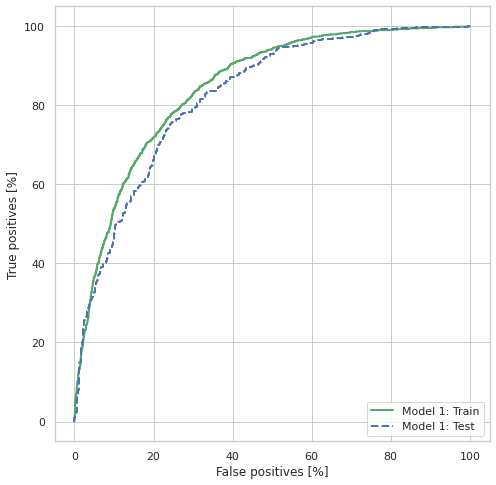

In [56]:
plt.figure(figsize=(8, 8))
plot_roc('Model 1: Train', y_train, y_pred_train_1, color='g')
plot_roc('Model 1: Test', y_test, y_pred_test_1, color='b', linestyle='--')
plt.legend(loc='lower right');

In [57]:
# Precision-Recall curve

from sklearn.metrics import precision_recall_curve

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)

    plt.plot(recall, precision, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

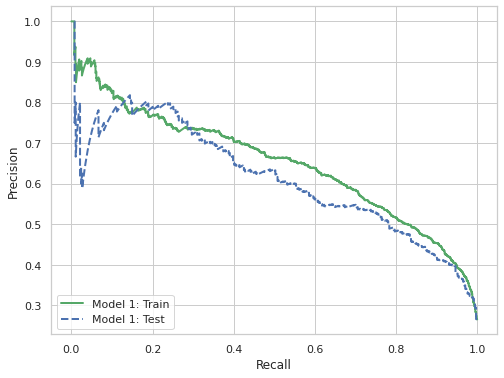

In [58]:
plt.figure(figsize=(8, 8))
plot_prc('Model 1: Train', y_train, y_pred_train_1, color='g')
plot_prc('Model 1: Test', y_test, y_pred_test_1, color='b', linestyle='--')
plt.legend(loc='lower left');

In [59]:
from sklearn.metrics import classification_report

target_names = ['not_churn', 'churn']
print(classification_report(y_test, y_pred_test_1 > 0.5, target_names=target_names))

              precision    recall  f1-score   support

   not_churn       0.83      0.89      0.86      1033
       churn       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



Let's define a **class weight** for our model in order to:

- Identify better the customers that has the positive label (churn), but as we don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [60]:
# Calculate class weights

weight_for_0 = (1 / not_churn) * (total / 2.0)
weight_for_1 = (1 / churn) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f'Weight for class 0: {weight_for_0:.2f}')
print(f'Weight for class 1: {weight_for_1:.2f}')

Weight for class 0: 0.68
Weight for class 1: 1.88


I will also define to train for longer and add a callback early stopping to the model stop since there is no more improvement and also add a dropout layer to reduce overfitting.

In [61]:
#define the model:
EPOCHS = 100
BATCH_SIZE = 256

# number of features
n_features = X_train.shape[-1]

# Set random seed
tf.random.set_seed(42)

# Create a model
model_2 = tf.keras.Sequential([
          tf.keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(10, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(), # lr as default: 1e-3(0.001)
                metrics=METRICS
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# Fit the model
history_2 = model_2.fit(X_train,
                        y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        callbacks=[early_stopping],
                        validation_data=(X_test, y_test),
                        class_weight=class_weight) # added the class weights

Epoch 1/100
22/22 [==============================] - 3s 62ms/step - loss: 0.8709 - tp: 199.0000 - fp: 130.0000 - tn: 5033.0000 - fn: 1670.0000 - accuracy: 0.7440 - precision: 0.6049 - recall: 0.1065 - auc: 0.5961 - prc: 0.3751 - val_loss: 0.5849 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1033.0000 - val_fn: 374.0000 - val_accuracy: 0.7342 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5962 - val_prc: 0.3096
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.7278 - tp: 40.0000 - fp: 91.0000 - tn: 4039.0000 - fn: 1455.0000 - accuracy: 0.7252 - precision: 0.3053 - recall: 0.0268 - auc: 0.5420 - prc: 0.2896 - val_loss: 0.6103 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 1032.0000 - val_fn: 374.0000 - val_accuracy: 0.7335 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6601 - val_prc: 0.3629
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 0.6949 - tp: 109.0000 - fp: 234.0000 - tn: 3896.0000 - f

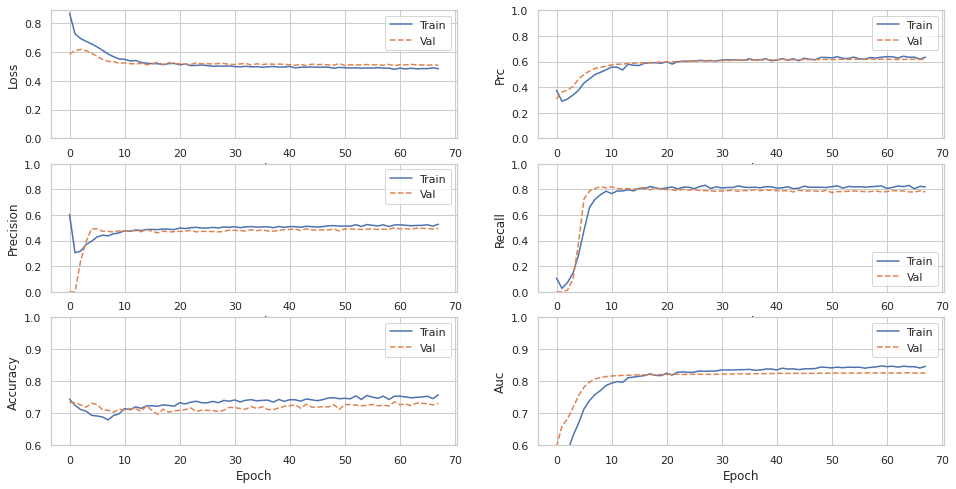

In [62]:
plot_metrics(history_2)

In [63]:
results_model_2 = get_results(model_2, 'model_2')
results_model_2

metric_names,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
results_model_2,0.509,293.0,305.0,728.0,81.0,0.726,0.49,0.783,0.827,0.621


Not Churn Predicted Correctly (True Negatives):  728
Churn Predicted Incorrectly - Customers who actually still with the company (False Positives):  305
Not Churn Predicted Incorrectly - Customers who actually left the company (False Negatives):  81
Churn Predicted Correctly (True Positives):  293
Total Customers that really left the company:  374


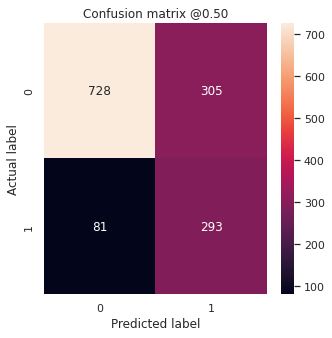

In [64]:
# prediction probabilities for the training and testing set
y_pred_train_2 = model_2.predict(X_train, batch_size=BATCH_SIZE)
y_pred_test_2 = model_2.predict(X_test, batch_size=BATCH_SIZE)

plot_cm(y_test, y_pred_test_2)

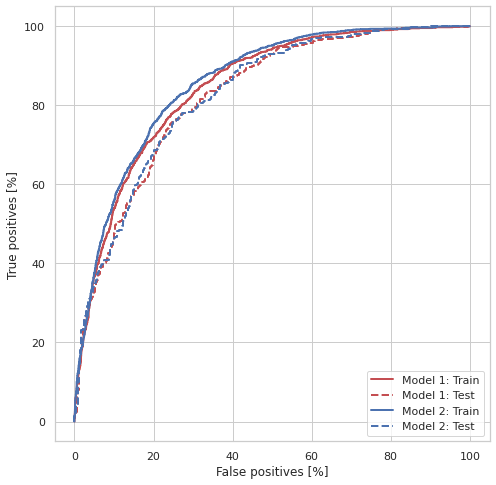

In [65]:
plt.figure(figsize=(8, 8))
plot_roc('Model 1: Train', y_train, y_pred_train_1, color='r')
plot_roc('Model 1: Test', y_test, y_pred_test_1, color='r', linestyle='--')
plot_roc('Model 2: Train', y_train, y_pred_train_2, color='b')
plot_roc('Model 2: Test', y_test, y_pred_test_2, color='b', linestyle='--')
plt.legend(loc='lower right');

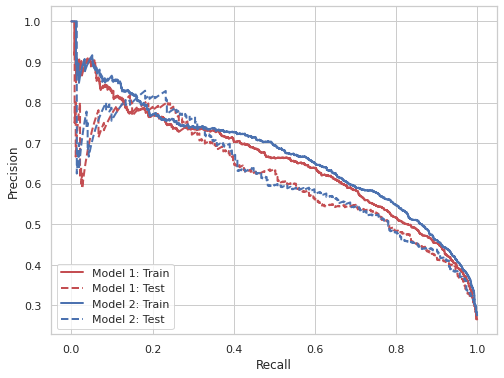

In [66]:
plt.figure(figsize=(8, 8))
plot_prc('Model 1: Train', y_train, y_pred_train_1, color='r')
plot_prc('Model 1: Test', y_test, y_pred_test_1, color='r', linestyle='--')
plot_prc('Model 2: Train', y_train, y_pred_train_2, color='b')
plot_prc('Model 2: Test', y_test, y_pred_test_2, color='b', linestyle='--')
plt.legend(loc='lower left');

In [67]:
target_names = ['not_churn', 'churn']
print(classification_report(y_test, y_pred_test_2 > 0.5, target_names=target_names))

              precision    recall  f1-score   support

   not_churn       0.90      0.70      0.79      1033
       churn       0.49      0.78      0.60       374

    accuracy                           0.73      1407
   macro avg       0.69      0.74      0.70      1407
weighted avg       0.79      0.73      0.74      1407



Adding class weights made our model identify more True Positives but also predicted wrongly more False Positives.

### **Feature Engineering**

In order to get a better performace, let's try the follow:
- `Removing features`: Many features might be useless or noisy and removing them might result in better scores, our model might be able to classify easier  and also speed up the training. I will remove some features based on the exploratory data analysis.

Dropping the redundant columns: 'gender', 'PhoneService' and 'MultipleLines'

In [68]:
df1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,No,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [69]:
# Create X (features) & y (labels) values, but now we are dropping also redundant columns: 'gender', 'PhoneService' and 'MultipleLines'
X = df1.drop(['gender', 'PhoneService', 'MultipleLines', 'Churn'], axis=1)
y = df1['Churn']

# Getting the columns name for the preprocessing data pipeline
numerical_columns = X.select_dtypes('number').columns
categorical_columns = X.select_dtypes('object').columns

In [70]:
#Preprocessing data (Normalization and One Hot Encoding)

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder

# Create column transformer (this will help us normalize/preprocess our data)
ct = make_column_transformer(
    (MinMaxScaler(), numerical_columns), # get all values between 0 and 1
    (OneHotEncoder(handle_unknown='ignore'), categorical_columns)
)

# ensure all numerical data are floating point values
X[numerical_columns] = X[numerical_columns].astype('float32')

# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # set random state for reproducible splits
print('Before applying the Preprocessing data:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
X_train = ct.transform(X_train)
X_test = ct.transform(X_test)
print('After applying the Preprocessing data:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Before applying the Preprocessing data: (5625, 16) (1407, 16) (5625,) (1407,)
After applying the Preprocessing data: (5625, 33) (1407, 33) (5625,) (1407,)


Also, making the model deeper with one extra layer and using the same class weights

In [93]:
#define the model:
EPOCHS = 100
BATCH_SIZE = 125

# number of features
n_features = X_train.shape[-1]

# Set random seed
tf.random.set_seed(42)

# Create a model
model_3 = tf.keras.Sequential([
          tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(16, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(10, activation='relu'),
          tf.keras.layers.Dropout(0.1),
          tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(), # lr as default: 1e-3(0.001)
                metrics=METRICS
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# Fit the model
history_3 = model_3.fit(X_train,
                        y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        callbacks=[early_stopping],
                        validation_data=(X_test, y_test),
                        class_weight=class_weight) # added the class weights

Epoch 1/100
45/45 [==============================] - 6s 47ms/step - loss: 0.6742 - tp: 1080.0000 - fp: 1892.0000 - tn: 3271.0000 - fn: 789.0000 - accuracy: 0.6187 - precision: 0.3634 - recall: 0.5778 - auc: 0.6660 - prc: 0.4147 - val_loss: 0.5869 - val_tp: 261.0000 - val_fp: 270.0000 - val_tn: 763.0000 - val_fn: 113.0000 - val_accuracy: 0.7278 - val_precision: 0.4915 - val_recall: 0.6979 - val_auc: 0.7981 - val_prc: 0.5778
Epoch 2/100
45/45 [==============================] - 0s 3ms/step - loss: 0.5905 - tp: 1015.0000 - fp: 1197.0000 - tn: 2933.0000 - fn: 480.0000 - accuracy: 0.7019 - precision: 0.4589 - recall: 0.6789 - auc: 0.7621 - prc: 0.5123 - val_loss: 0.5315 - val_tp: 284.0000 - val_fp: 286.0000 - val_tn: 747.0000 - val_fn: 90.0000 - val_accuracy: 0.7328 - val_precision: 0.4982 - val_recall: 0.7594 - val_auc: 0.8141 - val_prc: 0.6052
Epoch 3/100
45/45 [==============================] - 0s 3ms/step - loss: 0.5508 - tp: 1085.0000 - fp: 1089.0000 - tn: 3041.0000 - fn: 410.0000 - acc

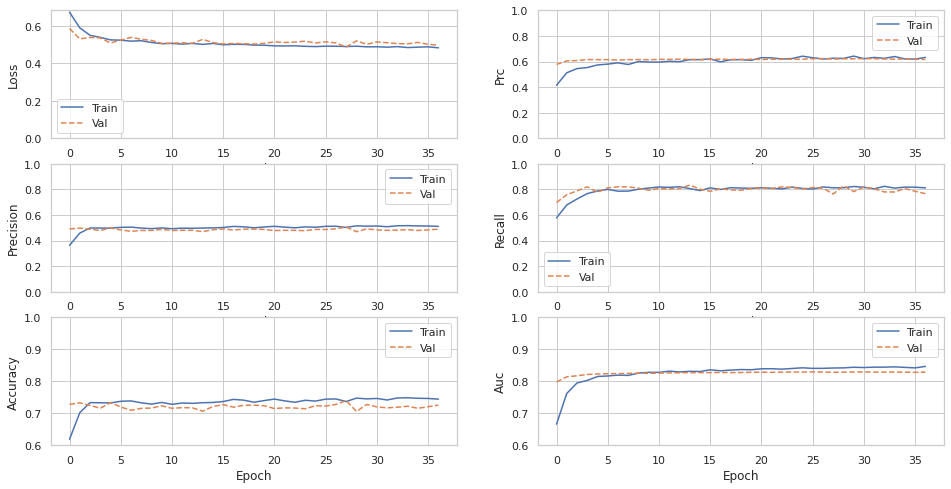

In [94]:
plot_metrics(history_3)

In [95]:
results_model_3 = get_results(model_3, 'model_3')
results_model_3

metric_names,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
results_model_3,0.51,303.0,312.0,721.0,71.0,0.728,0.493,0.81,0.829,0.624


Not Churn Predicted Correctly (True Negatives):  721
Churn Predicted Incorrectly - Customers who actually still with the company (False Positives):  312
Not Churn Predicted Incorrectly - Customers who actually left the company (False Negatives):  71
Churn Predicted Correctly (True Positives):  303
Total Customers that really left the company:  374


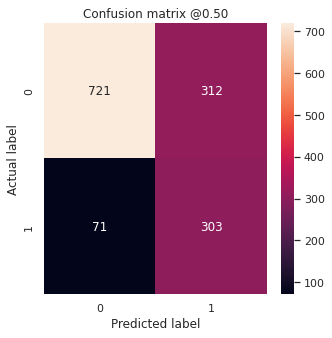

In [96]:
# prediction probabilities for the training and testing set
y_pred_train_3 = model_3.predict(X_train, batch_size=BATCH_SIZE)
y_pred_test_3 = model_3.predict(X_test, batch_size=BATCH_SIZE)

plot_cm(y_test, y_pred_test_3)

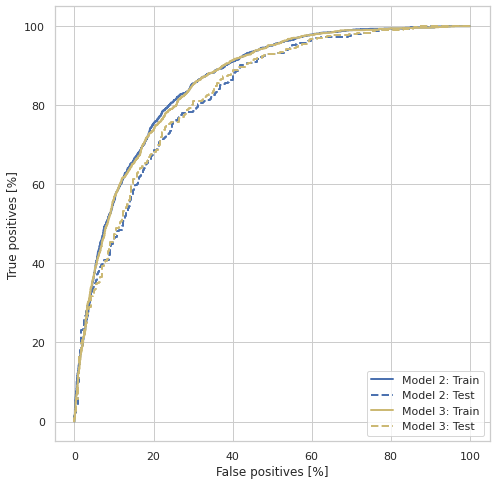

In [97]:
plt.figure(figsize=(8, 8))

plot_roc('Model 2: Train', y_train, y_pred_train_2, color='b')
plot_roc('Model 2: Test', y_test, y_pred_test_2, color='b', linestyle='--')
plot_roc('Model 3: Train', y_train, y_pred_train_3, color='y')
plot_roc('Model 3: Test', y_test, y_pred_test_3, color='y', linestyle='--')
plt.legend(loc='lower right');

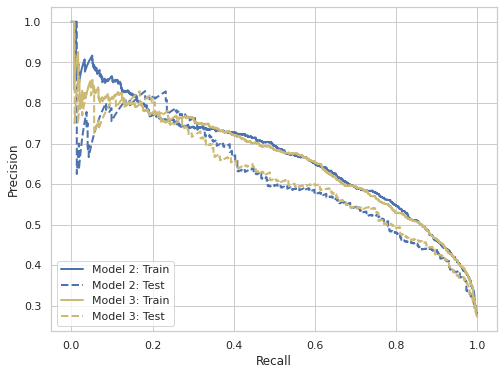

In [98]:
plt.figure(figsize=(8, 8))
plot_prc('Model 2: Train', y_train, y_pred_train_2, color='b')
plot_prc('Model 2: Test', y_test, y_pred_test_2, color='b', linestyle='--')
plot_prc('Model 3: Train', y_train, y_pred_train_3, color='y')
plot_prc('Model 3: Test', y_test, y_pred_test_3, color='y', linestyle='--')
plt.legend(loc='lower left');

In [99]:
target_names = ['not_churn', 'churn']
print(classification_report(y_test, y_pred_test_3 > 0.5, target_names=target_names))

              precision    recall  f1-score   support

   not_churn       0.91      0.70      0.79      1033
       churn       0.49      0.81      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.74      1407



Conclusions from the models and Precision Recall Curve above:
- We can see for different thresholds a linear correlation between our classifier model, meaning that the proportion to get a higher recall score affects the precision score in the same magnitude.

In [100]:
frames = [results_model_1, results_model_2, results_model_3]

results = pd.concat(frames)
results

metric_names,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
results_model_1,0.439,189.0,114.0,919.0,185.0,0.787,0.624,0.505,0.825,0.612
results_model_2,0.509,293.0,305.0,728.0,81.0,0.726,0.490,0.783,0.827,0.621
results_model_3,0.510,303.0,312.0,721.0,71.0,0.728,0.493,0.810,0.829,0.624


Making a **robust Model Evaluation** using the k-fold cross-validation procedure:
- With **StratifiedKFold**, The folds are made by preserving the percentage of samples for each class.

In [205]:
from sklearn.model_selection import StratifiedKFold

# Create X (features) & y (labels) values, but now we are dropping also redundant columns: 'gender', 'PhoneService' and 'MultipleLines'
X = df1.drop(['gender', 'PhoneService', 'MultipleLines', 'Churn'], axis=1)
y = df1['Churn']

# Getting the columns name for the preprocessing data pipeline
numerical_columns = X.select_dtypes('number').columns
categorical_columns = X.select_dtypes('object').columns

# Create column transformer (this will help us normalize/preprocess our data)
ct = make_column_transformer(
    (MinMaxScaler(), numerical_columns), # get all values between 0 and 1
    (OneHotEncoder(handle_unknown='ignore'), categorical_columns)
)

# ensure all numerical data are floating point values
X[numerical_columns] = X[numerical_columns].astype('float32')

# Calculate class weights
weight_for_0 = (1 / not_churn) * (total / 2.0)
weight_for_1 = (1 / churn) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

# Setting 10 folds
kfold = StratifiedKFold(n_splits=10, shuffle=True)

results = []
i = 0

for train_ix, test_ix in kfold.split(X, y):
  i += 1
  print(f'Fold {i} training')

  # split data
  X_train, X_test, y_train, y_test = X.iloc[train_ix], X.iloc[test_ix], y.iloc[train_ix], y.iloc[test_ix]
  print('Before applying the Preprocessing data:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

  # Fit column transformer on the training data only (doing so on test data would result in data leakage)
  ct.fit(X_train)

  # Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
  X_train = ct.transform(X_train)
  X_test = ct.transform(X_test)
  print('After applying the Preprocessing data:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

  #define the model:
  EPOCHS = 100
  BATCH_SIZE = 125

  # number of features
  n_features = X_train.shape[-1]

  # Set random seed
  tf.random.set_seed(42)

  # Create a model
  model = tf.keras.Sequential([
            tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(10, activation='relu'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compile the model
  model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(), # lr as default: 1e-3(0.001)
                  metrics=METRICS
  )

  early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_prc', 
      verbose=0,
      patience=10,
      mode='max',
      restore_best_weights=True)

  # Fit the model
  history = model.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=[early_stopping],
                      validation_data=(X_test, y_test),
                      verbose=0,
                      class_weight=class_weight) # added the class weights

  model_results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
  metric_names = model.metrics_names

  data = {'metric_names': metric_names, f'results_split_{i}': model_results}
  result = pd.DataFrame(data=data).set_index('metric_names').round(3).transpose()
  results.append(result)

Fold 1 training
Before applying the Preprocessing data: (6328, 16) (704, 16) (6328,) (704,)
After applying the Preprocessing data: (6328, 33) (704, 33) (6328,) (704,)
Fold 2 training
Before applying the Preprocessing data: (6328, 16) (704, 16) (6328,) (704,)
After applying the Preprocessing data: (6328, 33) (704, 33) (6328,) (704,)
Fold 3 training
Before applying the Preprocessing data: (6329, 16) (703, 16) (6329,) (703,)
After applying the Preprocessing data: (6329, 33) (703, 33) (6329,) (703,)
Fold 4 training
Before applying the Preprocessing data: (6329, 16) (703, 16) (6329,) (703,)
After applying the Preprocessing data: (6329, 33) (703, 33) (6329,) (703,)
Fold 5 training
Before applying the Preprocessing data: (6329, 16) (703, 16) (6329,) (703,)
After applying the Preprocessing data: (6329, 33) (703, 33) (6329,) (703,)
Fold 6 training
Before applying the Preprocessing data: (6329, 16) (703, 16) (6329,) (703,)
After applying the Preprocessing data: (6329, 33) (703, 33) (6329,) (703,

In [206]:
results = pd.concat(results)
results

metric_names,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
results_split_1,0.511,161.0,165.0,352.0,26.0,0.729,0.494,0.861,0.850,0.651
results_split_2,0.456,151.0,141.0,376.0,36.0,0.749,0.517,0.807,0.867,0.704
results_split_3,0.524,145.0,147.0,370.0,41.0,0.733,0.497,0.780,0.810,0.564
results_split_4,0.464,148.0,131.0,385.0,39.0,0.758,0.530,0.791,0.851,0.666
results_split_5,0.524,146.0,157.0,359.0,41.0,0.718,0.482,0.781,0.814,0.627
results_split_6,0.501,158.0,156.0,360.0,29.0,0.737,0.503,0.845,0.843,0.661
results_split_7,0.478,154.0,137.0,379.0,33.0,0.758,0.529,0.824,0.850,0.663
results_split_8,0.487,133.0,136.0,380.0,54.0,0.730,0.494,0.711,0.829,0.641
results_split_9,0.481,157.0,149.0,367.0,30.0,0.745,0.513,0.840,0.866,0.713
results_split_10,0.492,152.0,142.0,374.0,35.0,0.748,0.517,0.813,0.839,0.640


In [207]:
results.describe().loc[['mean', 'std']]

metric_names,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
mean,0.491800,150.500000,146.100000,370.200000,36.400000,0.740500,0.507600,0.805300,0.841900,0.65300
std,0.023361,8.072587,10.743991,10.601887,8.002777,0.013243,0.016071,0.042976,0.019428,0.04143


The robust evaluation shows that the last model (model_3) configuration works well for this dataset. We also increase the recall score from 50% to 80% but decreased the Precision and the Accuracy. Imbalance data classification is a difficult task and we could continue doing more EDA and modeling to find out which features may be relevant so the model could get the most out of your minority class.